## Track Statistics (Slope, Starting coordinate, Ending coordinate)

#### This program is an attempt to show how STF works and the calculation of slopes of tracks.

In [3]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
from scipy import misc
import imageio
from sklearn.metrics import auc
from sklearn import metrics
import math
import random
from scipy import stats
import sklearn
from sklearn.metrics import accuracy_score

In [4]:
pi=math.pi
tan=math.tan
cos=math.cos
sin=math.sin
exp=math.exp
sqrt=math.sqrt

In [5]:
image=mpimg.imread(r"\Users\Kaustav Dutta\Desktop\white_100.png",)
freq_min=10
freq_max=image.shape[1]
t_min=10
t_max=image.shape[0]
mean_life=15

Actual angle: 12.890406446739632
------------------After taking consecutive pixels------------------


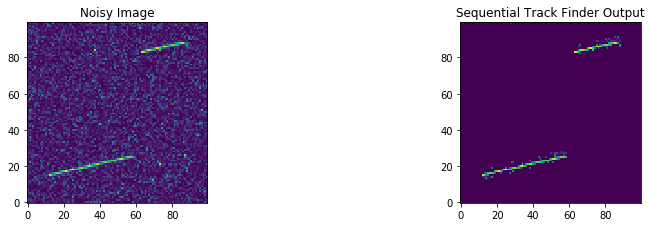

No. of track(s) found: 3
--------------Stats for track----------
Start x coord: 14
Start y coord: 14
End x coord: 18
End y coord: 17
Slope: 11.459155902616464
--------------Stats for track----------
Start x coord: 23
Start y coord: 17
End x coord: 56
End y coord: 25
Slope: 13.481359885431134
--------------Stats for track----------
Start x coord: 66
Start y coord: 82
End x coord: 85
End y coord: 88
Slope: 15.75633936609764


In [474]:
fig=1
accuracy_hist=[]
start=time.time()
for N in range(fig):

    pixel_threshold=5
    angle_dim=100
    window_size=6
    n_std=2.1
    th_consecutive=3
    max_spacing=25
    
    w0=random.randint(freq_min,15)
    t0=random.randint(t_min,15)
    
    alpha=random.uniform(0.775,1.39626)
    print("Actual angle:",90-np.degrees(alpha))
    SNR=2.0
    sigma=0.45

    image=mpimg.imread(r"\Users\Kaustav Dutta\Desktop\white_100.png",)
    pixel=get_image(image,w0,t0,alpha)
    pixel_gray=get_gray(pixel)
    th_true=np.mean(pixel)+np.std(pixel)
    binary_gray=get_binary_gray(pixel_gray,th_true)
    img=get_pixel_new(pixel_gray)

    #end = time.time()
    #print(end-start, "seconds")
    
    print("------------------After taking consecutive pixels------------------")
    plt.figure(figsize=(11,11))
    plt.subplot(131), plt.imshow(img,origin='lower'),plt.title('Noisy Image')
    binary_final=sequential_track_finder(img,window_size)
    plt.subplot(133),plt.imshow(binary_final,origin='lower'),plt.title('Sequential Track Finder Output')
    plt.show()
    
    start_x,start_y,end_x,end_y,slope_avg=get_track_stats(binary_final,window_size)
    
    print("No. of track(s) found:",len(start_x))
    for track in range(len(start_x)):
        print("--------------Stats for track----------")
        print("Start x coord:",start_y[track])
        print("Start y coord:",start_x[track])
        print("End x coord:",end_y[track])
        print("End y coord:",end_x[track])
        print("Slope:",slope_avg[track])
    

In [443]:
def get_image(image,w0,t0,angle):
    start=time.time()
    t_prev=t0
    freq_prev=w0
    
    while(True):
        scatter_time=math.floor(t_prev+10+np.random.exponential(mean_life))  #Scattering times follow an exponential distribution
       # scatter_time=random.randint(t_prev+mean_life,t_prev+3*mean_life) 
        scatter_freq=round(((scatter_time-t_prev)/tan(angle))+freq_prev)
        if((scatter_time>=t_max)or(scatter_freq>=freq_max)):
            break
            
        ybar=freq_prev
        xbar=t_prev
    
        for i in range(t_prev,scatter_time):
            for j in range(freq_prev,scatter_freq):
                intensity=SNR*exp(-((((j-ybar))*sin(alpha))-(((i-xbar))*cos(alpha)))**2/(2*(sigma)**2))
                image[j,i]=(intensity,intensity,0)
                
        t_prev=scatter_time+3
        freq_prev=int(scatter_freq+get_energy_loss())
        
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if (image[i,j][0]==image[i,j][1]==image[i,j][2]==1):
                image[i,j]=(0,0,0)
    end=time.time()
    #print("Time:get_image()",end-start)
    return image

In [7]:
def get_energy_loss():
    u=np.random.uniform(0,1)
    if(u<=0.48):
        gen_loss=np.random.normal(12.6,0.925)
    else:
        while(True):
            gen_loss=stats.cauchy.rvs(14.1,6.25)
            if(gen_loss>=14.1):break
    return(gen_loss)

In [8]:
def get_gray(pixel):
    start=time.time()
    pixel_gray=np.dot(pixel,[1,1,1])
    end=time.time()
   # print("Time:get_gray()",end-start)
    return pixel_gray

In [9]:
def get_binary_gray(pixel_gray,th_true):
    start=time.time()
    binary_gray=np.zeros(shape=(pixel_gray.shape[0],pixel_gray.shape[1]))
    for i in range(pixel_gray.shape[0]):
        for j in range(pixel_gray.shape[1]):
            binary_gray[i,j]=0 if (pixel_gray[i,j]<(th_true*np.max(pixel_gray))) else 1
    end=time.time()
   # print("Time:get_binary_gray",end-start)
    return binary_gray

In [10]:
def get_pixel_new(pixel_gray):
    start=time.time()
    noise=np.random.exponential(1.0,pixel_gray.shape)    
    pixel_new = SNR*pixel_gray+noise
    end=time.time()
   # print("Time:get_pixel_gray()",end-start)
    return pixel_new

In [419]:
def sequential_track_finder(img,size):
    
    binary_final=np.zeros(shape=img.shape)
    #binary_final=binary_final/255
    for x in range(img.shape[0]):
        max_intensity=np.max(img[x,:])
        for y in range(img.shape[1]):
            if(img[x,y]>=(max_intensity-6)and img[x,y]<=(max_intensity)):
                window_sum=np.sum(img[x-int(size/2):x+int(size/2),y-int(size/2):y+int(size/2)])
                if(window_sum>65):
                    binary_final[x,y]=img[x,y]
                    
    return binary_final

In [470]:
def get_track_stats(binary_final,size):
    start_x=[]
    start_y=[]
    end_x=[]
    end_y=[]
    slope_avg=[]
    vacant_row=1
    y=-1
    x=0
    x_ref=0
    while(y<binary_final.shape[1]-1):
        y=y+1
        track_pixel=0
        sum=np.sum(binary_final[:,y])
        if(sum>=5):
            for x in range(int(size/2),binary_final.shape[0]-int(size/2)): #This is for checking the starting pixel coordinates of a track
                if(binary_final[x,y]>0):
                    window_sum=np.sum(binary_final[x-int(size/2):x+int(size/2),y-int(size/2):y+int(size/2)])
                    if(window_sum>=60):
                        track_pixel=1
                        start_x.append(x)
                        start_y.append(y)
                        break
                    else:
                        track_pixel=0
       # print(y)
        if(track_pixel==1):
            pixel_prev_y=y
            pixel_prev_x=x
            pixel_count=1
            slope_sum=0
            vacant_row_total=0
            while(y<binary_final.shape[0]-1):
                y=y+1
                if(np.sum(binary_final[:,y])>0):
                    for x in range(int(size/2),binary_final.shape[0]-int(size/2)): #This is for checking the ending pixel coordinates of a track
                    
                        if(binary_final[x,y]>0):
                            window_sum=np.sum(binary_final[x-int(size/2):x+int(size/2),y-int(size/2):y+int(size/2)])
                            if(window_sum>=60):
                                pixel_count=pixel_count+1
                                if(y==pixel_prev_y):
                                    slope_sum=slope_sum+90
                                slope_sum=slope_sum+np.degrees((x-pixel_prev_x)/(y-pixel_prev_y))
                                pixel_prev_x=x
                                pixel_prev_y=y
                                vacant_row=0  #This means that the bright pixels in a row are actually track pixels
                                x_ref=x
                                break
                            else:
                                vacant_row=1  #This means that the bright pixels in a row are actually noise
                #print(vacant_row)
                if(np.sum(binary_final[:,y])==0 or vacant_row==1):
                    vacant_row_total=vacant_row_total+1
                    vacant_row=1
                
                if(vacant_row_total==3):
                    #print(y-2)
                    end_y.append(y-3)
                    end_x.append(x_ref)
                    slope_avg.append((slope_sum/pixel_count))
                    break    

    return start_x,start_y,end_x,end_y,slope_avg